In [11]:
import numpy as np
import pandas as pd
from sklearn import linear_model

In [3]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                           2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                           4.5, 4.75, 5., 5.5])
hours.reshape(1, -1).T

array([[0.5 ],
       [0.75],
       [1.  ],
       [1.25],
       [1.5 ],
       [1.75],
       [1.75],
       [2.  ],
       [2.25],
       [2.5 ],
       [2.75],
       [3.  ],
       [3.25],
       [3.5 ],
       [4.  ],
       [4.25],
       [4.5 ],
       [4.75],
       [5.  ],
       [5.5 ]])

# Using logistic regression

In [9]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                           index_col=0, parse_dates=True).dropna()
symbol = 'GLD'
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)

# Define numbers of lag days
lags = 3

# Construct data
cols = []
for lag in range(1, lags + 1):
             col = 'lag_{}'.format(lag)  
             data[col] = data['return'].shift(lag)  
             cols.append(col)
data.dropna(inplace=True)

In [12]:
from sklearn.metrics import accuracy_score
# Instantiates the model object using a C value that gives less weight to the regularization term (see the Generalized Linear Models page).
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)
lm.fit(data[cols], np.sign(data['return']))

data['prediction'] = lm.predict(data[cols])
data['prediction'].value_counts()

/root/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


prediction
 1.0    1975
-1.0     537
Name: count, dtype: int64

In [13]:
# Compute accuracy by accuracy_score
accuracy_score(data['prediction'], np.sign(data['return']))

0.5362261146496815

In [14]:
# Strategy return from prediction
data['strategy'] = data['prediction'] * data['return']

# Final return
data[['return', 'strategy']].sum().apply(np.exp)

return      1.289478
strategy    2.469257
dtype: float64

<Axes: xlabel='Date'>

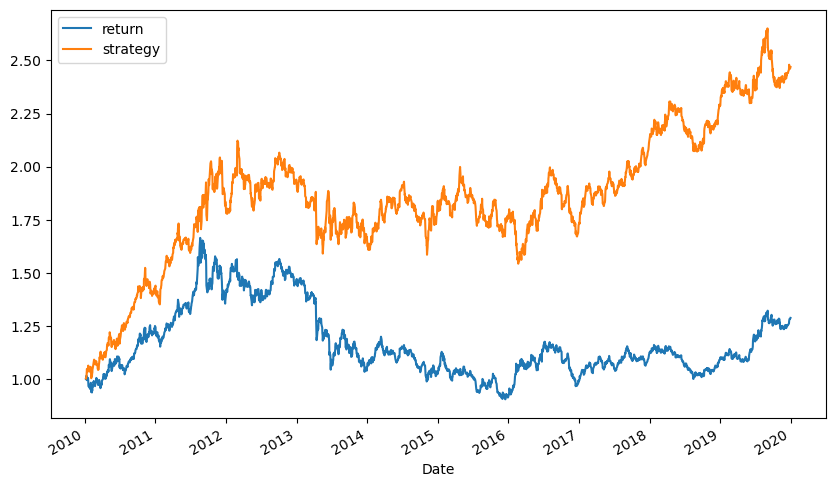

In [15]:
# Plot the cumulative return
data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

The hit ratio can be high but the gross performance can be lower

In [16]:
data[['return', 'strategy']].cumsum().apply(np.exp).iloc[-1]

return      1.289478
strategy    2.469257
Name: 2019-12-31 00:00:00, dtype: float64

# Build the function

/root/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/root/function/ScikitVectorBacktester.py:116: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the origina

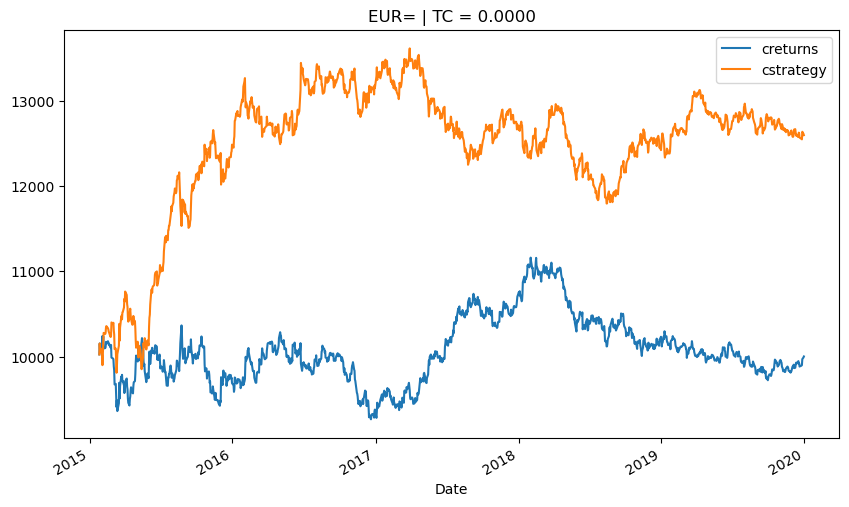

In [24]:
from function.ScikitVectorBacktester import ScikitVectorBacktester as SCI

# Set trans cost = 0, initial value = 10000, applying logistic function
scibt = SCI('EUR=', '2010-1-1', '2019-12-31', 10000, 0.0000, 'logistic')
scibt.run_strategy('2015-1-1', '2019-12-31', '2015-1-1', '2019-12-31', lags=15)
scibt.plot_results()